Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

# Forests of randomized trees

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt

from sklearn.utils import resample

### Set random seed to ensure reproducible runs

In [2]:
RSEED = 50

### Importing data and data cleaning

In [3]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_main.csv', index_col='rgiid')
df_main.columns

Index(['Unnamed: 0', 'x', 'y', 'Surge', 'Area', 'Slope', 'TermType', 'Name',
       'bed', 'thickness', 'surface_elevation', 'ELA', 'beta', 'cmb',
       'width_centerline', 'Runoff'],
      dtype='object')

In [4]:
df_main['WH'] = df_main['width_centerline'] / df_main['thickness']
df_main['WHsin'] = df_main['thickness']*df_main['width_centerline']*np.sin(df_main['Slope'])
df_main['dummy'] = np.random.rand(df_main.shape[0])

In [5]:
df_main.columns

Index(['Unnamed: 0', 'x', 'y', 'Surge', 'Area', 'Slope', 'TermType', 'Name',
       'bed', 'thickness', 'surface_elevation', 'ELA', 'beta', 'cmb',
       'width_centerline', 'Runoff', 'WH', 'WHsin', 'dummy'],
      dtype='object')

In [6]:
df_main.drop(df_main[df_main['Surge']==9].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==1].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==2].index, inplace = True)
df = df_main.drop(columns = ['Unnamed: 0','x', 'y', 'ELA', 'beta', 'Name', 'Area'])
df.dropna(how='any', inplace=True)

In [7]:
df

,Surge,Slope,TermType,bed,thickness,surface_elevation,cmb,width_centerline,Runoff,WH,WHsin,dummy
rgiid,,,,,,,,,,,,
RGI60-07.00004,0,13.8,0,889.68555,25.314478,915.00000,1.392706,279.780932,1.100061,11.052210,6683.732353,0.871170
RGI60-07.00004,0,13.8,0,882.06460,30.935455,913.00000,1.391001,295.980219,1.094416,9.567670,8640.744376,0.066971
RGI60-07.00004,0,13.8,0,882.06460,30.935455,913.00000,1.389296,330.851846,1.088771,10.694908,9658.774620,0.863637
RGI60-07.00004,0,13.8,0,882.06460,30.935455,913.00000,1.387591,342.886985,1.083127,11.083948,10010.124318,0.603733
RGI60-07.00004,0,13.8,0,881.31860,34.681380,916.00000,1.385886,336.403639,1.077530,9.699834,11010.043050,0.339472
...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01567,3,11.7,0,237.64468,50.380424,288.02512,-1.412920,278.553621,2.123592,5.529005,-10693.410549,0.165516
RGI60-07.01567,3,11.7,0,233.07228,46.717087,279.78937,-1.423469,256.755923,2.127417,5.495975,-9139.908345,0.115787
RGI60-07.01567,3,11.7,0,233.07228,46.717087,279.78937,-1.395654,238.477978,2.076787,5.104727,-8489.256385,0.843354


In [8]:
df_main.groupby('Surge').count()

,Unnamed: 0,x,y,Area,Slope,TermType,Name,bed,thickness,surface_elevation,ELA,beta,cmb,width_centerline,Runoff,WH,WHsin,dummy
Surge,,,,,,,,,,,,,,,,,,
0,68813,68813,68813,68813,68813,68813,48314,68813,68813,68813,68752,68752,68752,68707,68813,68707,68707,68813
3,10906,10906,10906,10906,10906,10906,10827,10906,10906,10906,10897,10897,10897,10905,10906,10905,10905,10906


In [9]:
df['Surge'] = df['Surge'].replace({3: 1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    68675
1    10897
Name: label, dtype: int64

In [10]:
df['label']

rgiid
RGI60-07.00004    0
RGI60-07.00004    0
RGI60-07.00004    0
RGI60-07.00004    0
RGI60-07.00004    0
                 ..
RGI60-07.01567    1
RGI60-07.01567    1
RGI60-07.01567    1
RGI60-07.01567    1
RGI60-07.01567    1
Name: label, Length: 79572, dtype: int64

In [11]:
df.columns

Index(['label', 'Slope', 'TermType', 'bed', 'thickness', 'surface_elevation',
       'cmb', 'width_centerline', 'Runoff', 'WH', 'WHsin', 'dummy'],
      dtype='object')

In [11]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [13]:
train_labels.sum()/train_labels.shape[0]

0.1369479353680431

In [14]:
test_labels.sum()/test_labels.shape[0]

0.136938672922252

In [15]:
missing_data = df.isna()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

Slope
False    79572
Name: Slope, dtype: int64

TermType
False    79572
Name: TermType, dtype: int64

bed
False    79572
Name: bed, dtype: int64

thickness
False    79572
Name: thickness, dtype: int64

surface_elevation
False    79572
Name: surface_elevation, dtype: int64

cmb
False    79572
Name: cmb, dtype: int64

width_centerline
False    79572
Name: width_centerline, dtype: int64

Runoff
False    79572
Name: Runoff, dtype: int64

WH
False    79572
Name: WH, dtype: int64

WHsin
False    79572
Name: WHsin, dtype: int64

dummy
False    79572
Name: dummy, dtype: int64



In [16]:
4081/81683

0.04996143628417174

In [17]:
# Features for feature importances
features = list(train.columns)
features

['Slope',
 'TermType',
 'bed',
 'thickness',
 'surface_elevation',
 'cmb',
 'width_centerline',
 'Runoff',
 'WH',
 'WHsin',
 'dummy']

In [18]:
train.shape

(55700, 11)

In [19]:
train_labels.shape

(55700,)

In [20]:
test.shape

(23872, 11)

### Evaluate the decision tree

In [21]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'k', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'm', label = 'model')
    plt.text(s = 'AUC = ' + str(round(roc_auc_score(train_labels, train_probs),2))
    , x=0.6, y=0.0, fontsize=15
)
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

### Random forest

In [22]:
df.columns

Index(['Slope', 'TermType', 'bed', 'thickness', 'surface_elevation', 'cmb',
       'width_centerline', 'Runoff', 'WH', 'WHsin', 'dummy'],
      dtype='object')

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=1000, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               max_depth = 2,
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.5s finished


RandomForestClassifier(max_depth=2, max_features='sqrt', n_estimators=1000,
                       n_jobs=-1, random_state=50, verbose=1)

In [24]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 7
Average maximum depth 2


In [25]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Paral

In [26]:
pd.DataFrame({'true':test_labels, 'predictions':rf_predictions, 'probs':rf_probs}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/ROC_curve/df_compare_roc_RF_centerline_area.csv')

/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall Baseline: 1.0 Test: 0.0 Train: 0.0
Precision Baseline: 0.14 Test: 0.0 Train: 0.0
Roc Baseline: 0.5 Test: 0.79 Train: 0.8


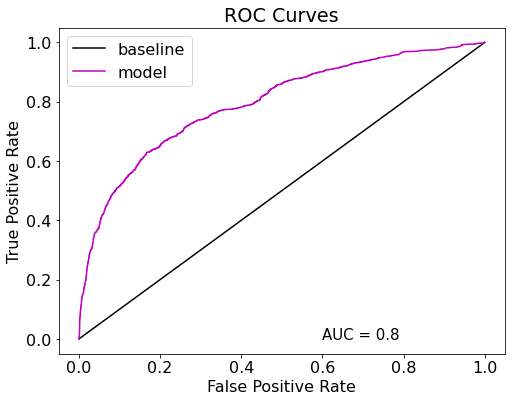

In [27]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [28]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    cbar = plt.colorbar(aspect=4)
    plt.clim(0,100)
    cbar.set_label('Fraction (%)')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[86  0]
 [14  0]]


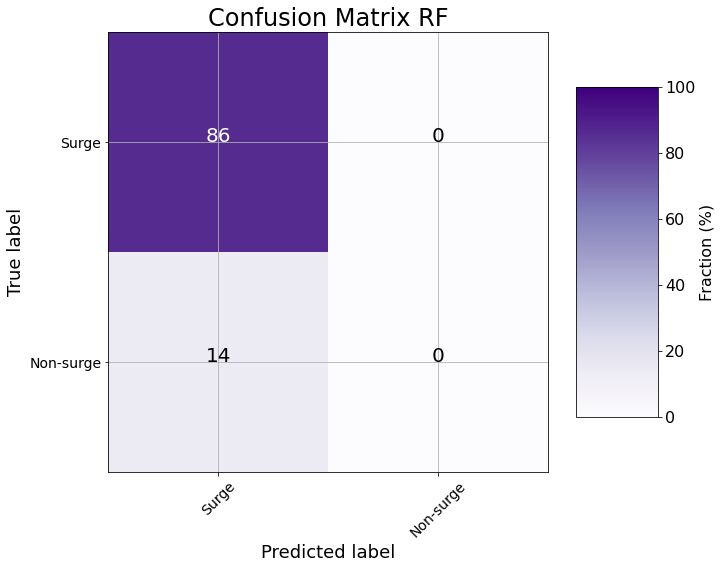

In [29]:
cm_rf = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(np.round(cm_rf/(test_labels.shape)*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix RF', cmap='Purples')

In [30]:
from sklearn.metrics import average_precision_score
average_precision_rf = average_precision_score(test_labels, rf_predictions)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_rf))

Average precision-recall score: 0.14


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished


Text(0.5, 1.0, '2-class Precision-Recall curve RF: AP=0.14')

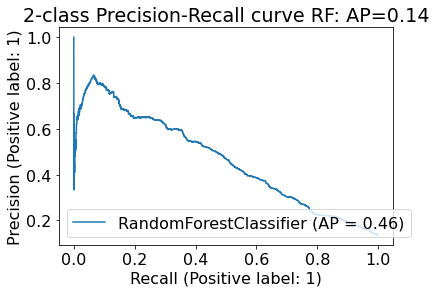

In [31]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp_rf = plot_precision_recall_curve(model, test, test_labels)
disp_rf.ax_.set_title('2-class Precision-Recall curve RF: '
                   'AP={0:0.2f}'.format(average_precision_rf))

In [32]:
tree = DecisionTreeClassifier(random_state=RSEED)
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 1775 nodes with maximum depth 25.


In [33]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
0,Slope,0.357655
5,cmb,0.160169
7,Runoff,0.090956
1,TermType,0.082255
9,WHsin,0.078649


# Gradient boosting

In [34]:
import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [35]:
# dmatrix_train = xgboost.DMatrix(train[train.columns[1:]], label=train_labels)
# dmatrix_test = xgboost.DMatrix(test[train.columns[1:]], label=test_labels)

dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test, label=test_labels)

In [36]:
params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.3}

xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

[16:29:08] WARNING: ../src/learner.cc:541: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [37]:
predictions_xgboost = xgb.predict(dmatrix_test)
pd.DataFrame({'true':test_labels, 'predictions':predictions_xgboost})
pd.DataFrame({'true':test_labels, 'predictions':predictions_xgboost}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/ROC_curve/df_compare_roc_xgboost_centerline_area.csv')

Text(0.6, 0.0, 'AUC = 0.92')

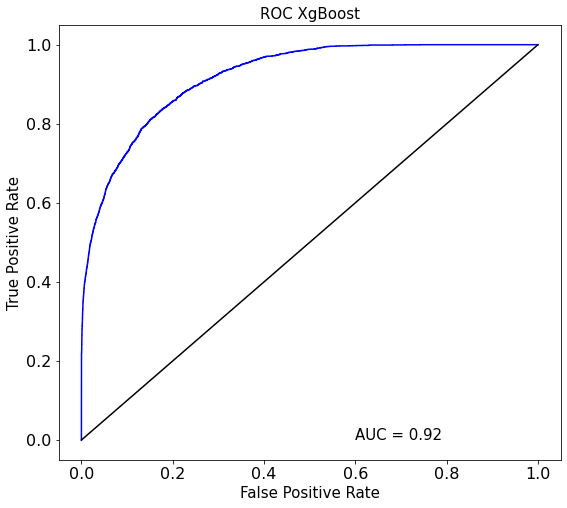

In [38]:
fpr, tpr, t = metrics.roc_curve(y_true=test_labels, y_score=predictions_xgboost)

fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr, 'b')
ax.plot([0, 1], [0, 1], 'k')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('ROC XgBoost', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=test_labels, y_score=predictions_xgboost),2))
    , x=0.6, y=0.0, fontsize=15
)

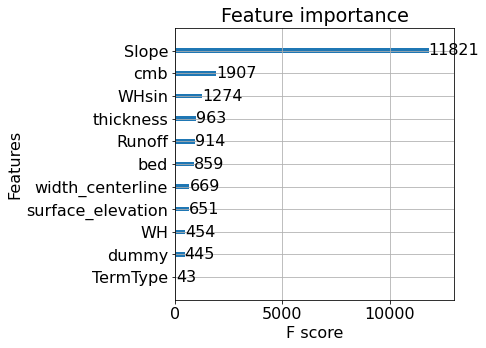

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, ax=ax)

In [40]:
average_precision_xgboost = average_precision_score(test_labels, predictions_xgboost)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_xgboost))

Average precision-recall score: 0.73


In [41]:
test_labels.dtype

dtype('int64')

Confusion matrix, without normalization
[[86  0]
 [ 9  4]]


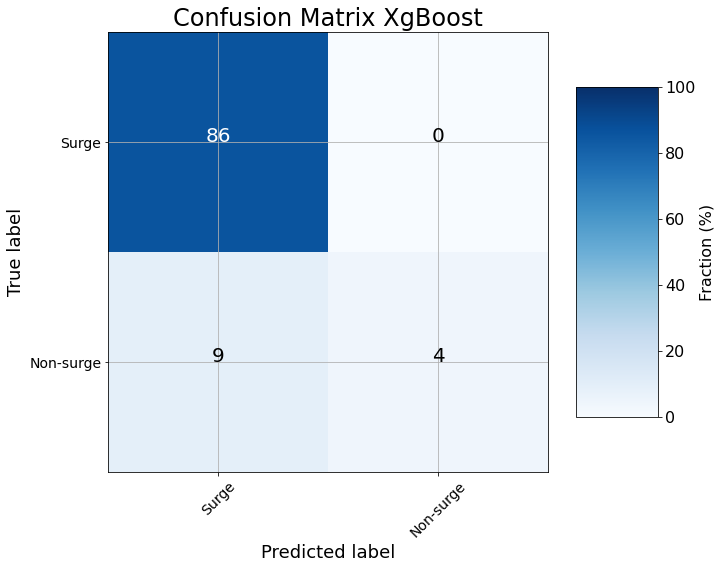

In [42]:
# confusion_matrix(test_labels, predictions.round())
cm_xgboost = confusion_matrix(test_labels, predictions_xgboost.round())
plot_confusion_matrix((cm_xgboost/test_labels.shape*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix XgBoost', cmap='Blues')

Theory: https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148

Example: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

# Logistic regression

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
logreg = LogisticRegression()
logreg.fit(train, train_labels)

LogisticRegression()

In [45]:
predictions_LR = logreg.predict(test)
probs_LR = logreg.predict_proba(test)[:, 1]
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test, test_labels)))

Accuracy of logistic regression classifier on test set: 0.86


In [46]:
test_labels.sum()

3269

In [47]:
pd.DataFrame({'true':test_labels, 'predictions':predictions_LR, 'prob':probs_LR}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/ROC_curve/df_compare_roc_LR_centerline_area.csv')

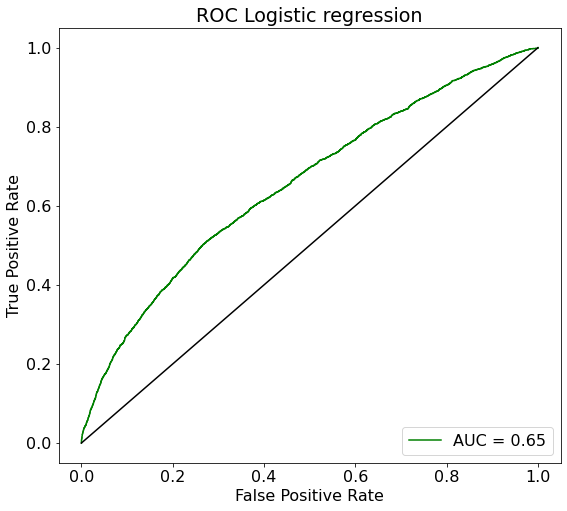

In [48]:
logit_roc_auc = roc_auc_score(test_labels, logreg.predict_proba(test)[:,1])
fpr, tpr, thresholds = roc_curve(test_labels, logreg.predict_proba(test)[:,1])
plt.figure(figsize=(9, 8))
plt.plot(fpr, tpr, 'g', label='AUC = %0.2f' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'k')
# # plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Logistic regression')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

<function confusion_matrix at 0x7ff9bc321a60>
Confusion matrix, without normalization
[[85  1]
 [12  0]]


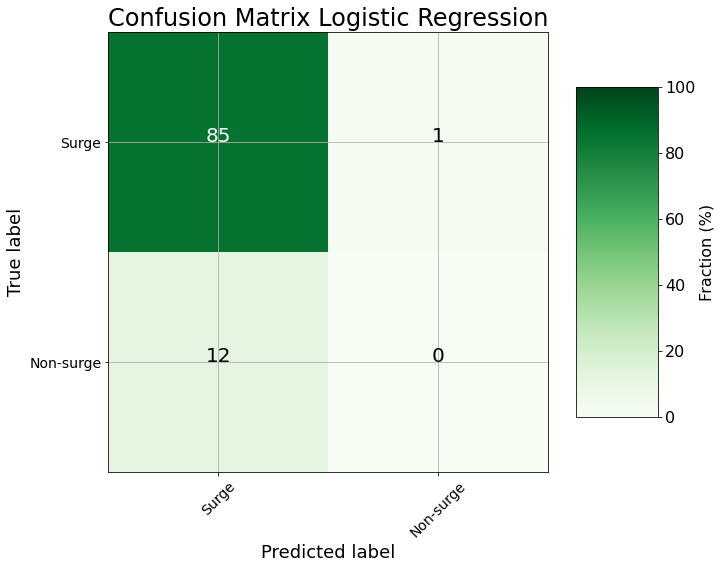

In [49]:
from sklearn.metrics import confusion_matrix
cm_LR = confusion_matrix(test_labels, predictions_LR)
print(confusion_matrix)
plot_confusion_matrix((cm_LR/test_labels.shape*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix Logistic Regression', cmap='Greens')

In [50]:
average_precision_LR = average_precision_score(test_labels, predictions_LR)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_LR))

Average precision-recall score: 0.15


Text(0.5, 1.0, '2-class Precision-Recall curve RF: AP=0.15')

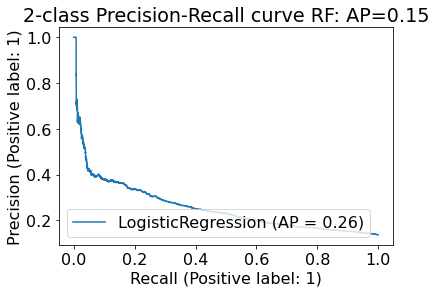

In [51]:
disp_lr = plot_precision_recall_curve(logreg, test, test_labels)
disp_lr.ax_.set_title('2-class Precision-Recall curve RF: '
                   'AP={0:0.2f}'.format(average_precision_LR))